In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/train"
test_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/test"
img_size = (224, 224)
batch_size = 32
epochs = 50  # İlk eğitim için epoch sayısı


# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 17524 files belonging to 8 classes.
Found 4384 files belonging to 8 classes.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam

# Ortak giriş verisi
input_tensor = Input(shape=(224, 224, 3))

# EfficientNetB0 tabanlı model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_base.output)

# ResNet50 tabanlı model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

# Özelliklerin birleştirilmesi
combined = concatenate([efficientnet_output, resnet_output])

# Fully connected katmanlar
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

# Model oluşturma
model = Model(inputs=input_tensor, outputs=output)


# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_resnet50_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 486s 653ms/step - accuracy: 0.7830 - loss: 0.6510 - val_accuracy: 0.7751 - val_loss: 0.9494
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 227s 413ms/step - accuracy: 0.8526 - loss: 0.4490 - val_accuracy: 0.8761 - val_loss: 0.3338
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 224s 409ms/step - accuracy: 0.8761 - loss: 0.3567 - val_accuracy: 0.8914 - val_loss: 0.3126
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 224s 408ms/step - accuracy: 0.8840 - loss: 0.3347 - val_accuracy: 0.8894 - val_loss: 0.3114
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 222s 404ms/step - accuracy: 0.8857 - loss: 0.3236 - val_accuracy: 0.8928 - val_loss: 0.3007
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 223s 406ms/step - accuracy: 0.8889 - loss: 0.3166 - val_accuracy: 0.8921 - val_loss: 0.3079
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 220s 402ms/step - accuracy: 0.8924 - loss: 0.3035 - val_accuracy: 

In [3]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

# Modeli kaydet
model.save('hybrid_model.h5')
print("✅ Model başarıyla eğitildi ve kaydedildi!")

✅ Model başarıyla eğitildi ve kaydedildi!


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

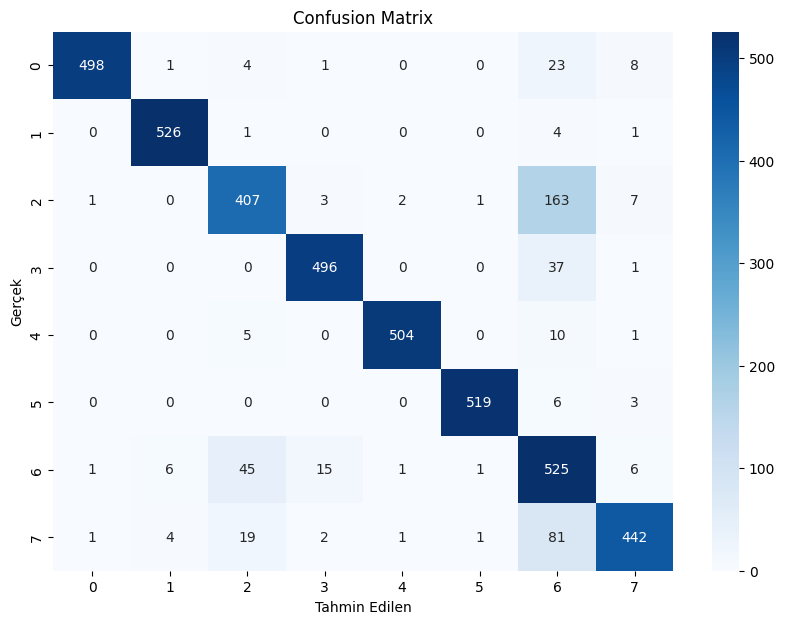

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

Attention

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate, Multiply, Conv2D, Activation, Reshape, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom Channel Attention Layer
class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.channel = input_shape[-1]
        self.shared_layer_one = Dense(self.channel // self.ratio, activation='relu', use_bias=False)
        self.shared_layer_two = Dense(self.channel, use_bias=False)
        super(ChannelAttention, self).build(input_shape)

    def call(self, input_feature):
        avg_pool = GlobalAveragePooling2D()(input_feature)
        avg_pool = Reshape((1, 1, self.channel))(avg_pool)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)
        
        max_pool = tf.reduce_max(input_feature, axis=[1, 2], keepdims=True)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)
        
        cbam_feature = tf.keras.layers.Add()([avg_pool, max_pool])
        cbam_feature = Activation('sigmoid')(cbam_feature)
        
        return Multiply()([input_feature, cbam_feature])

    def compute_output_shape(self, input_shape):
        return input_shape

# Custom Spatial Attention Layer
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv = Conv2D(1, kernel_size=7, strides=1, padding='same', activation='sigmoid')
        super(SpatialAttention, self).build(input_shape)

    def call(self, input_feature):
        avg_pool = tf.reduce_mean(input_feature, axis=3, keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=3, keepdims=True)
        concat = concatenate([avg_pool, max_pool], axis=3)
        
        cbam_feature = self.conv(concat)
        
        return Multiply()([input_feature, cbam_feature])

    def compute_output_shape(self, input_shape):
        return input_shape

# Ortak giriş verisi
input_tensor = Input(shape=(224, 224, 3))

# EfficientNetB0 tabanlı model
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
efficientnet_output = efficientnet_base.output

# EfficientNetB0 çıkışına Channel ve Spatial Attention ekle
efficientnet_output = ChannelAttention()(efficientnet_output)
efficientnet_output = SpatialAttention()(efficientnet_output)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_output)

# ResNet50 tabanlı model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_output = resnet_base.output

# ResNet50 çıkışına Channel ve Spatial Attention ekle
resnet_output = ChannelAttention()(resnet_output)
resnet_output = SpatialAttention()(resnet_output)
resnet_output = GlobalAveragePooling2D()(resnet_output)

# Özelliklerin birleştirilmesi
combined = concatenate([efficientnet_output, resnet_output])

# Fully connected katmanlar
x = Dense(256, activation='relu')(combined)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

# Model oluşturma
model = Model(inputs=input_tensor, outputs=output)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_resnet50_cbam_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 482s 645ms/step - accuracy: 0.7732 - loss: 0.6730 - val_accuracy: 0.8652 - val_loss: 0.3815
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 227s 414ms/step - accuracy: 0.8573 - loss: 0.4071 - val_accuracy: 0.8686 - val_loss: 0.3380
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 226s 412ms/step - accuracy: 0.8721 - loss: 0.3591 - val_accuracy: 0.8864 - val_loss: 0.3089
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 223s 406ms/step - accuracy: 0.8823 - loss: 0.3351 - val_accuracy: 0.8855 - val_loss: 0.3145
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 225s 410ms/step - accuracy: 0.8853 - loss: 0.3157 - val_accuracy: 0.8942 - val_loss: 0.3012
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 225s 410ms/step - accuracy: 0.8902 - loss: 0.3038 - val_accuracy: 0.8921 - val_loss: 0.2947
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 225s 409ms/step - accuracy: 0.8932 - loss: 0.2941 - val_accuracy: 0.8932 - val_loss: 0.2975
Epoch 8/50
548/548 ━━━━━━

In [4]:
from tensorflow.keras.utils import plot_model

# Modelin görselini oluştur ve kaydet
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.398354 to fit



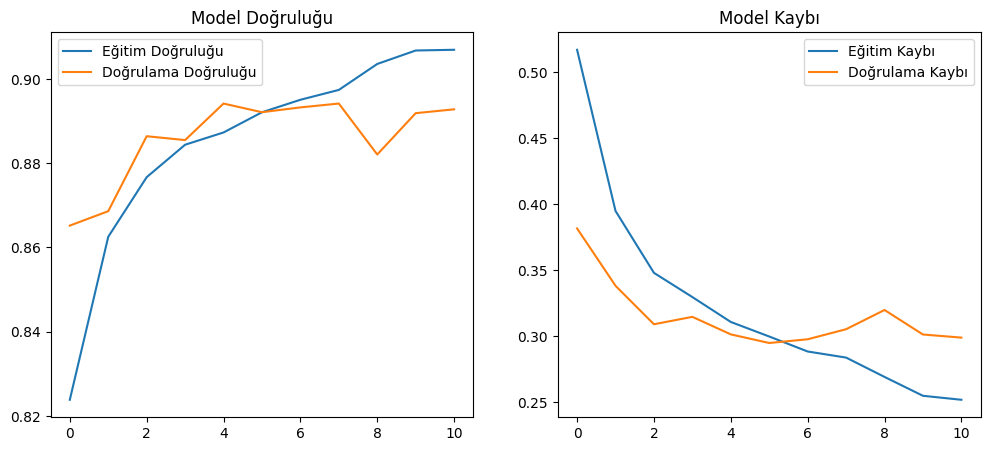

✅ Model başarıyla eğitildi ve kaydedildi!


In [5]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

# Modeli kaydet
model.save('hybrid_attention_model.h5')
print("✅ Model başarıyla eğitildi ve kaydedildi!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

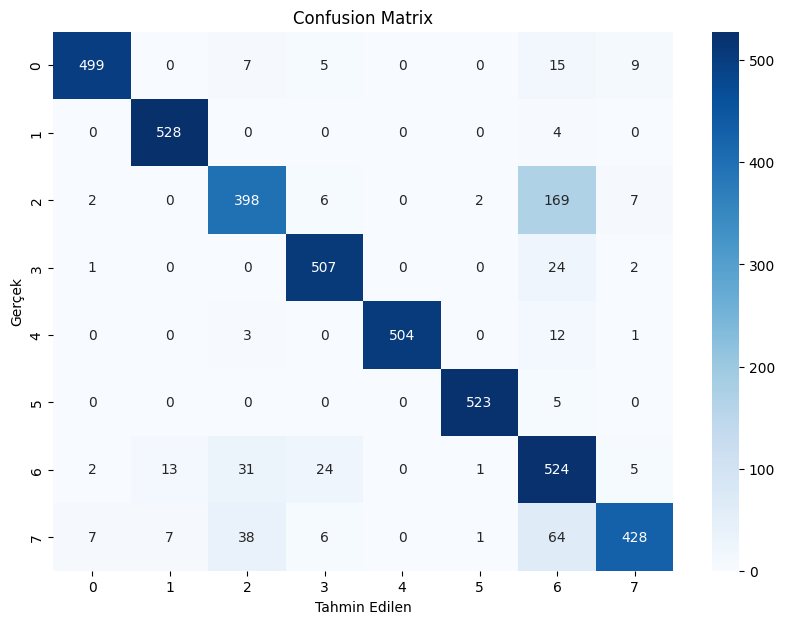

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()